In [19]:
import numpy as np
import sys
from scipy.stats import entropy
from scipy.special import rel_entr
from scipy.spatial.distance import cdist
import torch,torch.optim, torch.nn
import sklearn.datasets

In [28]:
def get_p_scores(X, perp, need_conditionals = False):
    
    N = len(X)
    
    target_h = np.log(perp)
    
    betas_max = np.ones(N)
    betas_min = np.ones(N)
    betas = np.ones(N)
    
    betas_max[:] = 10000
    betas_min[:] = 1
    
    betas[:] = (betas_max + betas_min) / 2
     
    conditionals = get_conditionals(X, betas)
    actual_h = entropy(conditionals, axis = 1)
    
    tolerance = 0.00001
    
    while np.sum(np.abs(actual_h - target_h) > tolerance) > 0:
        
        greater = (actual_h - target_h) > tolerance
        
        betas_max[greater] = betas[greater]
        
        lesser = (actual_h - target_h) < tolerance
        
        betas_min[lesser] = betas[lesser]
        
        need_change = np.abs(actual_h - target_h) > tolerance
        
        betas[need_change] = (betas_max[need_change] + betas_min[need_change]) / 2
        
        conditionals = get_conditionals(X, betas)
        
        actual_h = entropy(conditionals, axis = 1)
        
    probs_sym = (conditionals.T + conditionals) / (2 * len(X))

    return probs_sym

def get_conditionals(X, betas):
    
    dists = (cdist(X, X)**2) / betas[:, None]
    
    exp = np.exp(-dists)
    np.fill_diagonal(exp, 0)
    
    row_sums = np.sum(exp, axis = 1)[:, None]
    exp /= row_sums
    
    return exp

def compute_cost(p_scores, q_scores):
    eps=1e-7
    kl_loss = torch.nn.KLDivLoss(reduction = "sum", log_target = True)
    return kl_loss(torch.log(q_scores + eps), torch.log(p_scores + eps))

def get_q_scores(Y):
    
    q_scores = (torch.cdist(Y, Y)**2 + 1) **-1
    q_scores.fill_diagonal_(0)
            
    q_scores /= q_scores.sum()
    
    return q_scores

def init_y(X):
    return torch.tensor(np.random.normal(size = (len(X), 2), scale = 1.0))


In [33]:
dataset = sklearn.datasets.load_digits()

X = dataset['data']
T = dataset['target']
R = np.random.mtrand.RandomState(0).permutation(len(X))[:750]
X = X[R]
T = T[R]

p_scores = torch.tensor(get_p_scores(X, 30))
y = init_y(X)
y.requires_grad_(True)
print(y)

tensor([[ 0.7500, -2.0783],
        [-1.2262, -1.3449],
        [-0.4508,  0.8902],
        ...,
        [ 0.5895, -0.8189],
        [-0.1534, -0.5707],
        [ 0.3846,  0.5481]], dtype=torch.float64, requires_grad=True)


In [34]:
optimizer = torch.optim.SGD((y,), lr=100, momentum=0.95)

In [35]:
def train(p_scores, eg_factor = 12, n_iter = 500):
    
    for i in range(n_iter):
        # print(y)
        q_scores = get_q_scores(y)
        # print(q_scores)
        optimizer.zero_grad()
        if i < 50:
            J = compute_cost(p_scores * eg_factor, q_scores)
        else: 
            J = compute_cost(p_scores, q_scores)
            
        print(J.data.numpy())
        
        J.backward()
        optimizer.step()
        
        
    # print(y)
train(p_scores, eg_factor = 4)

18.726303854506174
18.318734175697394
17.67270518421736
17.224853681911625
16.748965328372236
16.048196165962423
15.221848155647866
14.416814979568121
13.744879075166525
13.241172433105497
12.790475925912988
12.377790437840723
11.996505103538013
11.678629220750505
11.45466957579067
11.221071829621213
10.99550883668913
10.838924770156266
10.706377114327937
10.563995127364297
10.449985593156356
10.366273254531727
10.302645336695086
10.23913962502805
10.167273342889152
10.093528901136752
10.040993426598153
10.002553891447851
9.953916909149143
9.88823488134056
9.833829106677893
9.799083663504248
9.769143351688552
9.725525869857409
9.673827061538912
9.634241727379342
9.609758288002865
9.589511048499674
9.560483486174558
9.524566900992639
9.493492844308795
9.464333505119852
9.432270839470286
9.40273841668777
9.373731462911243
9.345904119101926
9.323528396613574
9.30504156453151
9.287275914436844
9.264001660828605
0.8989003444808634
0.9035636418725687
0.9139292351711976
0.9239778780198171
0.9

0.6991345880757209
0.6990853999578955
0.6990402638055111
0.6989899575571523
0.6989288261321186
0.6988561311527923
0.6987755003631781
0.6986932300015554
0.6986152180346414
0.6985434510797303
0.6984747970507506
0.6984030284884892
0.6983216506287353
0.6982256215594943
0.6981122389520519
0.6979819465994495
0.6978388180163212
0.6976895967573261
0.6975410601038152
0.6973975390848174
0.6972605181339863
0.697130039486485
0.6970064004820348
0.696891198990763
0.6967874505413217
0.6966986733578321
0.6966270443830914
0.6965713416532604
0.6965260697345702
0.6964829015491778
0.6964339115546683
0.6963746355307927
0.6963053212628888
0.6962299705899239
0.6961539062325689
0.6960813103365753
0.6960139379308359
0.6959511894622193
0.6958909546247056
0.6958305823808453
0.6957676478668379
0.6957004682338493
0.6956284132793662
0.695552001553022
0.6954727186578196
0.6953925572702768
0.6953134133667017
0.6952365608755653
0.6951624034759921
0.6950905670889941
0.6950202213446589
0.6949504352100586
0.6948804331244

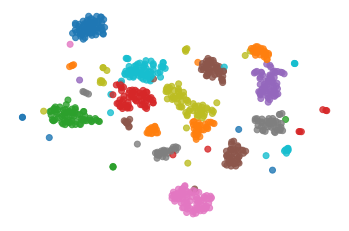

In [36]:
from matplotlib import pyplot as plt

# ax = fig.add_subplot(111)
plt.axis("off")

plt.scatter(y.detach().numpy()[:,0], y.detach().numpy()[:,1], c = T, cmap = "tab10", alpha = 0.8)
plt.savefig("T-SNE.pdf")